In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.model_selection import train_test_split

In [3]:
raw_data = pd.read_csv(r"/content/credit_risk_dataset.csv")

In [4]:
raw_data.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [5]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


In [6]:
raw_data["loan_status"].value_counts()

,count
loan_status,
0,25473
1,7108


In [7]:
round((len(raw_data[raw_data["loan_status"] == 1]) / len(raw_data) * 100), 2)

21.82

atleast the ratio should be 60:40, need to balance the data

In [8]:
raw_data.isna().sum()

,0
person_age,0
person_income,0
person_home_ownership,0
person_emp_length,895
loan_intent,0
loan_grade,0
loan_amnt,0
loan_int_rate,3116
loan_status,0
loan_percent_income,0


In [9]:
raw_data.duplicated().sum()

165

In [10]:
raw_data.drop_duplicates(inplace=True)

In [11]:
raw_data.shape

(32416, 12)

**Will be working on the variables perseon_emp_length and loan_int_rate**

**Target and inputs**

In [12]:
inputs_df = raw_data.drop(["loan_status"], axis=1)
target = raw_data["loan_status"]

In [13]:
categorical_columns = inputs_df.select_dtypes(include=["object"]).columns
numerical_columns = inputs_df.select_dtypes(exclude=["object"]).columns

In [14]:
categorical_columns

Index(['person_home_ownership', 'loan_intent', 'loan_grade',
       'cb_person_default_on_file'],
      dtype='object')

In [15]:
def value_counts(df, column):
  return df[column].value_counts() / len(inputs_df)

In [16]:
value_counts(inputs_df, "person_home_ownership")

# The people who are apying the money over the period of time to buy the home eventually at specific period they will buy it
# So, with the above mindset I will be combining the MORTGAGE and OWN classes and will drop OTHER class as they have 0.3 % of the dataset
# will check if it can't help to perform model well then I will consider not to drop it

,count
person_home_ownership,
RENT,0.505244
MORTGAGE,0.412420
OWN,0.079066
OTHER,0.003270


In [17]:
inputs_df = inputs_df[inputs_df["person_home_ownership"] != "OTHER"]

In [18]:
map_ownership = {"RENT" : 0, "MORTGAGE" : 1, "OWN" : 1}

inputs_df["person_home_ownership"] = inputs_df["person_home_ownership"].map(map_ownership)

In [19]:
inputs_df["person_home_ownership"].unique()

array([0, 1])

In [20]:
value_counts(inputs_df, "loan_intent")

## almost all the classes are having nearly same ratio with small deviation

,count
loan_intent,
EDUCATION,0.197895
MEDICAL,0.186475
VENTURE,0.175085
PERSONAL,0.169607
DEBTCONSOLIDATION,0.160074
HOMEIMPROVEMENT,0.110864


In [21]:
map_loan_intent = {"EDUCATION" : 0,
                   "MEDICAL" : 1,
                   "VENTURE" : 2,
                   "PERSONAL" : 3,
                   "DEBTCONSOLIDATION" : 4,
                   "HOMEIMPROVEMENT" : 5}

inputs_df["loan_intent"] = inputs_df["loan_intent"].map(map_loan_intent)

In [22]:
value_counts(inputs_df, "loan_grade")

# as we can see here that A, B, C has the greater ratio and from D-G it has minimum ratio and coincidently they all represent to the default status
# we can combine D-G in one class say ----> D

,count
loan_grade,
A,0.330455
B,0.320458
C,0.198731
D,0.111421
E,0.029557
F,0.007397
G,0.001981


In [23]:
inputs_df["loan_grade"] = inputs_df["loan_grade"].replace(["D", "E", "F", "G"], "D")
inputs_df["loan_grade"].unique()

array(['D', 'B', 'C', 'A'], dtype=object)

In [24]:
map_loan_grade = {"A" : 0,
                  "B" : 1,
                  "C" : 2,
                  "D" : 3}

inputs_df["loan_grade"] = inputs_df["loan_grade"].map(map_loan_grade)

In [25]:
value_counts(inputs_df, categorical_columns[3])

# we will check after calculating the corr w.r.t the target variable
# will handle after converting the categorcial column to the numeric

,count
cb_person_default_on_file,
N,0.823553
Y,0.176447


In [26]:
map_default = {"Y" : 0, "N" : 1}

inputs_df["cb_person_default_on_file"] = inputs_df["cb_person_default_on_file"].map(map_default)

In [27]:
inputs_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32310 entries, 0 to 32580
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32310 non-null  int64  
 1   person_income               32310 non-null  int64  
 2   person_home_ownership       32310 non-null  int64  
 3   person_emp_length           31423 non-null  float64
 4   loan_intent                 32310 non-null  int64  
 5   loan_grade                  32310 non-null  int64  
 6   loan_amnt                   32310 non-null  int64  
 7   loan_int_rate               29228 non-null  float64
 8   loan_percent_income         32310 non-null  float64
 9   cb_person_default_on_file   32310 non-null  int64  
 10  cb_person_cred_hist_length  32310 non-null  int64  
dtypes: float64(3), int64(8)
memory usage: 3.0 MB


In [28]:
inputs_df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,0,123.0,3,3,35000,16.02,0.59,0,3
1,21,9600,1,5.0,0,1,1000,11.14,0.10,1,2
2,25,9600,1,1.0,1,2,5500,12.87,0.57,1,3
3,23,65500,0,4.0,1,2,35000,15.23,0.53,1,2
4,24,54400,0,8.0,1,2,35000,14.27,0.55,0,4


In [29]:
target_df = target.loc[inputs_df.index]

# dropping the same rows which I have dropped from inputs dataframe

In [30]:
len(target_df)

32310

**Will start working with numerical variables**

In [31]:
numerical_columns

Index(['person_age', 'person_income', 'person_emp_length', 'loan_amnt',
       'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length'],
      dtype='object')

In [32]:
inputs_df[numerical_columns].describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length
count,32310.000000,3.231000e+04,31423.000000,32310.000000,29228.000000,32310.000000,32310.000000
mean,27.749985,6.605729e+04,4.794132,9589.140359,11.014047,0.170181,5.812844
std,6.353880,6.193569e+04,4.145971,6323.246255,3.242954,0.106787,4.059636
min,20.000000,4.000000e+03,0.000000,500.000000,5.420000,0.000000,2.000000
25%,23.000000,3.850000e+04,2.000000,5000.000000,7.900000,0.090000,3.000000
50%,26.000000,5.500000e+04,4.000000,8000.000000,10.990000,0.150000,4.000000
75%,30.000000,7.920000e+04,7.000000,12200.000000,13.470000,0.230000,8.000000
max,144.000000,6.000000e+06,123.000000,35000.000000,23.220000,0.830000,30.000000


We can see here that there are outliers and have to deal with it

In [33]:
## outliers

def boxplot(columns):
    for col in columns:
        plt.figure(figsize=(8, 4))  # Adjusted figure size
        sns.boxplot(x=inputs_df[col])  # Explicitly set x-axis for clarity
        plt.title(f'Boxplot of {col}')  # Add title for each plot
        plt.tight_layout()  # Ensures proper layout
        plt.show()


/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


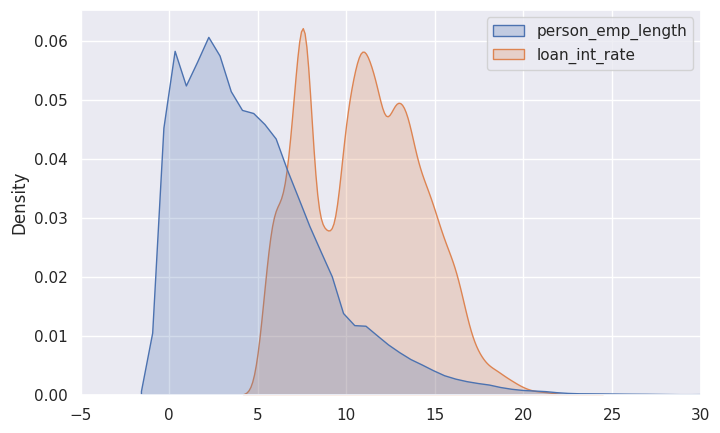

In [34]:
plt.figure(figsize = (8, 5))
sns.kdeplot(raw_data[["person_emp_length", "loan_int_rate"]], fill=True)
plt.xlim(-5, 30)
plt.show()

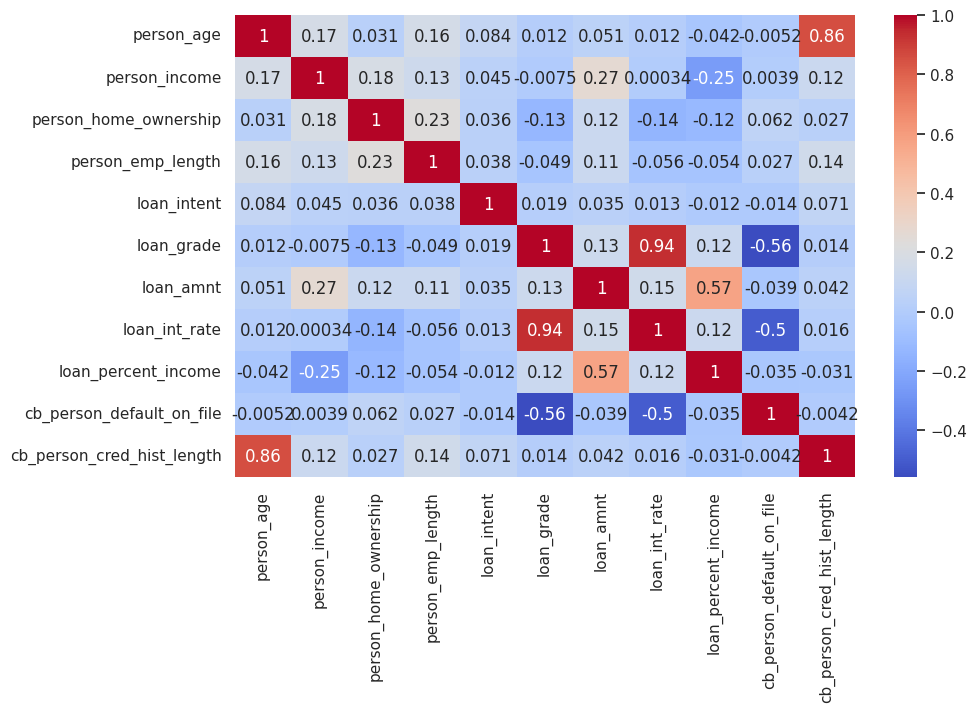

In [35]:
plt.figure(figsize = (10, 6))
corr_matrix = inputs_df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

Here I can see that loan_int_rate is highly correlated with loan_grade will substitue the missing values w.r.t loan_grad          
person_emp_length is slightly aligned with person_home_ownership

In [36]:
correlations = inputs_df.apply(lambda col: col.corr(target_df))

correlations

,0
person_age,-0.022601
person_income,-0.144767
person_home_ownership,-0.239789
person_emp_length,-0.082543
loan_intent,0.061365
loan_grade,0.358271
loan_amnt,0.105034
loan_int_rate,0.335689
loan_percent_income,0.378559
cb_person_default_on_file,-0.178633


In [37]:
data = inputs_df.copy()

In [38]:
data["loan_status"] = target_df

In [39]:
data.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,22,59000,0,123.0,3,3,35000,16.02,0.59,0,3,1
1,21,9600,1,5.0,0,1,1000,11.14,0.10,1,2,0
2,25,9600,1,1.0,1,2,5500,12.87,0.57,1,3,1
3,23,65500,0,4.0,1,2,35000,15.23,0.53,1,2,1
4,24,54400,0,8.0,1,2,35000,14.27,0.55,0,4,1


In [40]:
data.isna().sum()

,0
person_age,0
person_income,0
person_home_ownership,0
person_emp_length,887
loan_intent,0
loan_grade,0
loan_amnt,0
loan_int_rate,3082
loan_percent_income,0
cb_person_default_on_file,0


In [41]:
data.dropna(inplace=True)

In [42]:
data.shape

## There were about 32,480 data points now there are about 28400 data points after removing the missing values

(28408, 12)

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


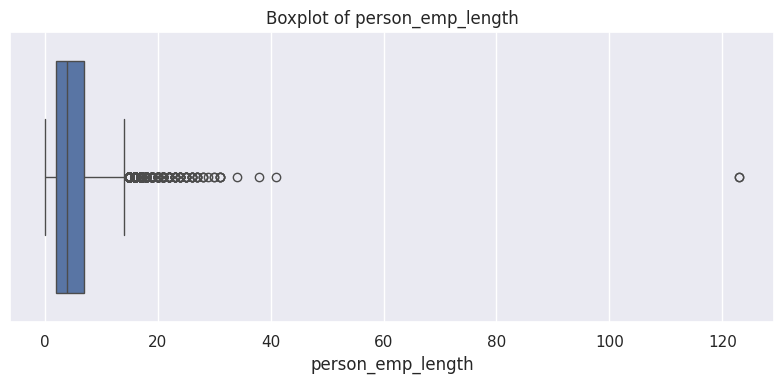

In [43]:
boxplot(["person_emp_length"])

In [44]:
## dropping the rows that having the age greater than 80
data = data[data["person_age"] < 80]
data = data[data["person_emp_length"] < 36]

In [45]:
data.shape

(28398, 12)

In [46]:
data.isna().sum()

,0
person_age,0
person_income,0
person_home_ownership,0
person_emp_length,0
loan_intent,0
loan_grade,0
loan_amnt,0
loan_int_rate,0
loan_percent_income,0
cb_person_default_on_file,0


**Splitting the dataset into training and testing data**

In [47]:
train_data, test_data, train_labels, test_labels = train_test_split(data.drop("loan_status", axis=1), data["loan_status"], test_size=0.2, random_state=369)

In [48]:
train_data.shape

(22718, 11)

In [49]:
test_data.shape

(5680, 11)

In [50]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from imblearn.under_sampling import RandomUnderSampler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

## models to apply
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier, BaggingClassifier

In [51]:
down_sample = RandomUnderSampler()

In [52]:
resample_train_data, resample_train_labels = down_sample.fit_resample(train_data, train_labels)

In [53]:
resample_train_data.shape

(9982, 11)

<ipython-input-54-a3ff99c0dde2>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=resample_train_labels, palette='coolwarm')
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


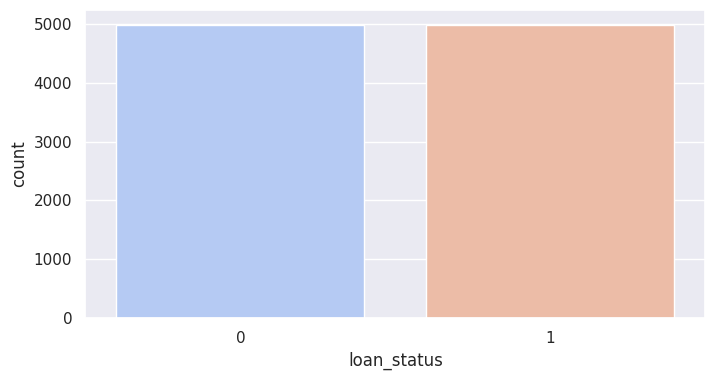

In [54]:
plt.figure(figsize=(8, 4))
sns.countplot(x=resample_train_labels, palette='coolwarm')
plt.show()

Now we have the balanced dataset now we can work on it

**Scaling the data**

In [55]:
scaler = StandardScaler()
min_max = MinMaxScaler()

In [56]:
## Random Forest Model
rf_model = RandomForestClassifier(n_estimators=150, n_jobs=-1, oob_score=True)
## Gradient Boosting Model
gb_model = GradientBoostingClassifier()
## logistic Regression Model
log_model = LogisticRegression()

In [57]:
# after applying the standard scaler the data will be converted to numpy
scaled_data = scaler.fit_transform(resample_train_data)

In [58]:
# converting train labels to numpy array
train_lables = resample_train_labels.values

In [59]:
# function to scale the provided data especially for test data
def test_scaling(test_data):
  scaled_test_data = scaler.transform(test_data)
  return scaled_test_data

In [60]:
test_scaled_data = test_scaling(test_data)
test_labels = test_labels.values

**Model Building**

In [61]:
n_estimators = np.arange(100, 150, 10)
max_depth = np.arange(3, 6, 1)
max_features = np.arange(2, 7)
max_samples = [0.4, 0.5, 0.75]

In [62]:
## Random Forest Model
params = {"n_estimators" : n_estimators,
             "max_depth" : max_depth,
             "max_features" : max_features,
             "max_samples" : max_samples}

In [63]:
rf_grid = GridSearchCV(estimator=rf_model,
                       param_grid=params,
                       cv=10,
                       n_jobs=-1)

In [64]:
rf_grid

GridSearchCV(cv=10,
             estimator=RandomForestClassifier(n_estimators=150, n_jobs=-1,
                                              oob_score=True),
             n_jobs=-1,
             param_grid={'max_depth': array([3, 4, 5]),
                         'max_features': array([2, 3, 4, 5, 6]),
                         'max_samples': [0.4, 0.5, 0.75],
                         'n_estimators': array([100, 110, 120, 130, 140])})

In [65]:
rf_grid.fit(scaled_data, resample_train_labels)

/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=10,
             estimator=RandomForestClassifier(n_estimators=150, n_jobs=-1,
                                              oob_score=True),
             n_jobs=-1,
             param_grid={'max_depth': array([3, 4, 5]),
                         'max_features': array([2, 3, 4, 5, 6]),
                         'max_samples': [0.4, 0.5, 0.75],
                         'n_estimators': array([100, 110, 120, 130, 140])})

In [66]:
rf_grid.best_params_

{'max_depth': 5, 'max_features': 6, 'max_samples': 0.75, 'n_estimators': 130}

In [67]:
rf_grid.best_estimator_

RandomForestClassifier(max_depth=5, max_features=6, max_samples=0.75,
                       n_estimators=130, n_jobs=-1, oob_score=True)

In [68]:
rf_grid.best_score_

0.8359080523409181

In [69]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [71]:
rf_grid_model = rf_grid.best_estimator_

rf_pred_labels = rf_grid_model.predict(test_scaled_data)

rf_accuracy = accuracy_score(test_labels, rf_pred_labels)

rf_report = classification_report(test_labels, rf_pred_labels)

rf_confusion_matrix = confusion_matrix(test_labels, rf_pred_labels)

In [72]:
rf_accuracy

0.8769366197183098

In [74]:
print(rf_report)

              precision    recall  f1-score   support

           0       0.94      0.91      0.92      4511
           1       0.68      0.77      0.72      1169

    accuracy                           0.88      5680
   macro avg       0.81      0.84      0.82      5680
weighted avg       0.88      0.88      0.88      5680



In [75]:
rf_confusion_matrix

array([[4085,  426],
       [ 273,  896]])

In [ ]:
n_estimators = np.arange(100, 150, 10)
max_depth = np.arange(3, 6, 1)
max_features = np.arange(2, 7)
ccp_alpha = [0.01, 0.03, 0.02]

In [ ]:
gb_params = {"n_estimators" : n_estimators,
          "max_depth" : max_depth,
          "max_features" : max_features,
          "ccp_alpha":  ccp_alpha}

In [ ]:
gb_grid = GridSearchCV(estimator=gb_model,
                       param_grid=gb_params,
                       cv=10,
                       n_jobs=-1)

In [ ]:
gb_grid.fit(scaled_data, resample_train_labels)

GridSearchCV(cv=10, estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid={'ccp_alpha': [0.01, 0.03, 0.02],
                         'max_depth': array([3, 4, 5]),
                         'max_features': array([2, 3, 4, 5, 6]),
                         'n_estimators': array([100, 110, 120, 130, 140])})

In [ ]:
gb_grid.best_params_

{'ccp_alpha': 0.01, 'max_depth': 3, 'max_features': 6, 'n_estimators': 120}

In [ ]:
gb_grid.best_estimator_

GradientBoostingClassifier(ccp_alpha=0.01, max_features=6, n_estimators=120)

In [ ]:
gb_grid.best_score_

0.8098941020941414

**Evaluations**

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [ ]:
final_model = gb_grid.best_estimator_

In [ ]:
pred_labels = final_model.predict(test_scaled_data)

In [ ]:
accuracy_score(test_labels, pred_labels)

0.8512828634779854

In [ ]:
confusion_matrix(test_labels, pred_labels)

array([[4359,  547],
       [ 392, 1016]])

In [ ]:
report = classification_report(test_labels, pred_labels)

In [ ]:
print(report)

              precision    recall  f1-score   support

           0       0.92      0.89      0.90      4906
           1       0.65      0.72      0.68      1408

    accuracy                           0.85      6314
   macro avg       0.78      0.81      0.79      6314
weighted avg       0.86      0.85      0.85      6314



In [ ]:
## I have done all things correctly, need to improve the model complexity